# COMP551 - Mini-Project 2 - Team 97

McGill University<br>
Authors: Shantanil Bagchi, Manoosh Samiei, Nikhil Podila

This is the implementation code for Mini-project 2

###### Note: Some sections of the code have been compiled from various sources in the internet and in relevent papers, which have been referenced in our final report.

In [25]:
import numpy as np
import pandas as pd
import time
import re 

'''Features'''
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import label_binarize
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import chi2, SelectKBest

'''Classifiers'''
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

'''Metrics/Evaluation'''
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score
from scipy import interp
from itertools import cycle

'''Plotting'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

'''Display'''
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

'''Classifiers'''
from sklearn.feature_extraction.text import CountVectorizer  
from sklearn.feature_extraction.text import TfidfTransformer  
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV

'''Lemmatizer'''
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

'''Stemmer'''
from nltk.stem.snowball import SnowballStemmer
#from nltk.stem import PorterStemmer

'''Progress  Bar'''
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

'''Stopwords Corpus'''
import nltk
from nltk.corpus import stopwords, wordnet
stop_words = set(stopwords.words('english'))



## Loading Data

In [3]:
print("Reading of the data files on process...")

df = pd.read_csv("reddit_train.csv")
test= pd.read_csv("reddit_test.csv")
print("Task Completed")
  
df.head()

Reading of the data files on process...
Task Completed


,id,comments,subreddits
0,0,"Honestly, Buffalo is the correct answer. I rem...",hockey
1,1,Ah yes way could have been :( remember when he...,nba
2,2,https://youtu.be/6xxbBR8iSZ0?t=40m49s\n\nIf yo...,leagueoflegends
3,3,He wouldn't have been a bad signing if we woul...,soccer
4,4,Easy. You use the piss and dry technique. Let ...,funny


## Checking for duplicate posts

In [4]:
# To check for duplicated data
df[df["comments"].duplicated()]

,id,comments,subreddits
280,280,\nVery short discussion posts are usually a si...,Music
313,313,Your submission has been removed because of th...,gameofthrones
369,369,**Spoiler Warning:** [EVERYTHING] means spoile...,gameofthrones
556,556,Your submission has been removed because of th...,gameofthrones
616,616,Your submission was removed because it looks l...,Music
...,...,...,...
69602,69602,In accordance with our [Low-effort Guidelines]...,Overwatch
69684,69684,[NO SPOILERS] means any comments with spoilers...,gameofthrones
69762,69762,Your submission has been automatically removed...,gameofthrones
69773,69773,"Your account is too new, so your submission ha...",gameofthrones


## Dropping Duplicate Post (not much useful)

In [5]:
# #To drop the duplicated data
# df=df.drop_duplicates(keep='first',subset='comments')
# df.shape

In [6]:
X_datatrain = df['comments']
y_datatrain = df['subreddits']
X_datatest = test['comments']  

## Preprocessing Data

In [7]:
#Progress bar
def process_data(data):
    data = data.progress_map(preprocess_data)  
    return data

#Preprocessing the data
def preprocess_data(review):
    document = cleaning_data(review)
    document = stopwords_data(document)
    #document = lemmatize_data(document)
    #document = stem_data(document)
    
    return document 

#### HTML removal, contraction removal, Lemmatizing, Stemming not useful so dropped

In [8]:
# Function to remove noise from text and deal with negation
def cleaning_data(comment):
    
    #Remove Non-ASCII characters
    comment = re.sub(r"\xa0",r" ",comment)
    comment = comment.encode("ascii", errors="ignore").decode()
    
    #Lower case the data
    comment = comment.lower()
    
    #Remove HTML Links
    #comment = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', ' ', comment)   
    #comment = re.sub(r'\n','',comment)
    
    #Cleaning the data by removing special characters
    comment = re.sub(r"[^A-Za-z0-9!?\'\`]", " ", comment)
    
     #Handling negations
    comment = re.sub(r"youtu.be", " youtube", comment)
    comment = re.sub(r"https", " http", comment)
    comment = re.sub(r"i'm", " i am", comment)
    #comment = re.sub(r"it's", " it is", comment)
    #comment = re.sub(r"ain't", "is not",comment)
    #comment = re.sub(r"aren't", "are not",comment)
    #comment = re.sub(r"couldn't", "could not",comment)
    #comment = re.sub(r"didnt", "did not",comment)
    #comment = re.sub(r"dont", "do not",comment)
    #comment = re.sub(r"doesn't", "does not",comment)
    #comment = re.sub(r"hadn't", "had not",comment)
    #comment = re.sub(r"hasn't", "has not",comment)
    #comment = re.sub(r"haven't", "have not",comment)
    #comment = re.sub(r"isn't", "is not",comment)
    #comment = re.sub(r"shouldn't", "should not",comment)
    #comment = re.sub(r"shan't", "shall not",comment)
    #comment = re.sub(r"wasn't", "was not",comment)
    #comment = re.sub(r"weren't", "were not",comment)
    #comment = re.sub(r"oughtn't", "ought not",comment)
    #comment = re.sub(r"that's", " that is", comment)
    comment = re.sub(r"\'s", " ", comment)
    #comment = re.sub(r"\'ve", " have", comment)
    #comment = re.sub(r"won't", " will not", comment)
    #comment = re.sub(r"wouldn't", " would not", comment)
    #comment = re.sub(r"don't", " do not", comment)
    #comment = re.sub(r"can't", " can not", comment)
    #comment = re.sub(r"cannot", " can not", comment)
    #comment = re.sub(r"n\'t", " n\'t", comment)
    #comment = re.sub(r"\'re", " are", comment)
    #comment = re.sub(r"\'d", " would", comment)
    #comment = re.sub(r"\'ll", " will", comment)    
    comment = re.sub(r"!", " ! ", comment)
    comment = re.sub(r"\?", " ? ", comment)
    comment = re.sub(r"\s{2,}", " ", comment)
    
    # Removing all the numbers
    comment = re.sub(r'[0-9]+', ' ', comment)
    
    #Removing all puncs
    comment = re.sub(r'[^\w\s]','',comment)
    
    # Substituting multiple spaces with single space
    comment = re.sub(r'\s+', ' ', comment, flags=re.I)
    
    # Remove single letters
    comment= re.sub(r"\b[a-zA-Z]\b","", comment)
        
    comment = [word for word in comment.split() if len(word) >= 2]
    comment = ' '.join(comment)
    
    return comment
  
#Removing the stop words
def stopwords_data(comment):
    more_stop_words = ["wa", "gt","amp", "u", "ha", "le", "doe", "don",'ve']
    stop_words_ = stop_words.union(more_stop_words)
    comment = [word for word in comment.split() if not word in stop_words_]
    comment = ' '.join(comment)           
    return comment
  
#Tag words by their parts of speech 
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

#Normalising the data by lemmatizing
def lemmatize_data(comment):
    comment = [lemmatizer.lemmatize(word,get_wordnet_pos(word)) for word in comment.split()]
    comment = ' '.join(comment)
    comment = [word for word in comment.split() if len(word) >= 3]
    comment = ' '.join(comment)
    return comment

#Normalise data by user-defined stemming
def stem(word):
    for suffix in ['ing', 'ly', 'ed', 'ious', 'ies', 'ive', 'es', 's', 'ment']:
        if word.endswith(suffix):
            return word[:-len(suffix)]
    return word

def stemmer(phrase):
    r=[]
    for word in phrase.split():
        r.append(stem(word))
    return ' '.join(r)
  
#Normalising the data by renowned stemming methods

stemmer=SnowballStemmer('english')
def stem_data(comment):
    comment = [stemmer.stem(word) for word in comment.split()]
    comment = ' '.join(comment)
    comment = [word for word in comment.split() if len(word) >= 3]
    comment = ' '.join(comment)
    return comment
    
#list of cleaned words
def cleandata(X_datatrain, X_datatest):
    cleandata_Train = []
    for sen in range(0, len(X_datatrain)): 
        cleandata_Train.append(preprocess_data(str(X_datatrain[sen])))
        
    cleandata_Test = []
    for sen in range(0, len(X_datatest)): 
        cleandata_Test.append(preprocess_data(str(X_datatest[sen])))
    return cleandata_Train, cleandata_Test

In [9]:
print("Cleaning of Training data on process...")
cleandata_Train = process_data(X_datatrain)
print("Task completed")
print("Cleaning of Testing data on process...")
cleandata_Test = process_data(X_datatest)
print("Task completed")

Cleaning of Training data on process...


progress-bar: 100%|██████████| 70000/70000 [00:04<00:00, 14716.63it/s]


Task completed
Cleaning of Testing data on process...


progress-bar: 100%|██████████| 30000/30000 [00:01<00:00, 15213.32it/s]


Task completed


# LDA Implementation

In [9]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [10]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(cleandata_Train))

print(data_words[:1])

[['honest', 'buffalo', 'correct', 'answer', 'rememb', 'peopl', 'somewhat', 'joke', 'buffalo', 'mantra', 'start', 'goali', 'win', 'game', 'get', 'trade', 'think', 'edmonton', 'front', 'offic', 'travesti', 'better', 'part', 'year', 'buffalo', 'systemat', 'destruct', 'term', 'competit', 'much', 'respons', 'chang', 'draft', 'lotteri']]


In [11]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['honest', 'buffalo', 'correct', 'answer', 'rememb', 'peopl', 'somewhat', 'joke', 'buffalo', 'mantra', 'start', 'goali', 'win', 'game', 'get', 'trade', 'think', 'edmonton', 'front_offic', 'travesti', 'better', 'part', 'year', 'buffalo', 'systemat', 'destruct', 'term', 'competit', 'much', 'respons', 'chang', 'draft_lotteri']


In [12]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [21]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
#python3 -m spacy download en
#import spacy
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['correct', 'somewhat', 'start', 'game', 'get', 'trade', 'think', 'well', 'term', 'competit', 'much', 'respon']]


In [22]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1)]]


In [23]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('competit', 1),
  ('correct', 1),
  ('game', 1),
  ('get', 1),
  ('much', 1),
  ('respon', 1),
  ('somewhat', 1),
  ('start', 1),
  ('term', 1),
  ('think', 1),
  ('trade', 1),
  ('well', 1)]]

In [24]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [26]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.156*"want" + 0.148*"team" + 0.148*"still" + 0.127*"come" + 0.082*"seem" + '
  '0.052*"comment" + 0.037*"close" + 0.028*"allow" + 0.020*"exact" + '
  '0.018*"face"'),
 (1,
  '0.115*"work" + 0.104*"bad" + 0.083*"great" + 0.061*"place" + 0.060*"pay" + '
  '0.048*"post" + 0.034*"system" + 0.031*"plea" + 0.030*"complet" + '
  '0.024*"amount"'),
 (2,
  '0.279*"much" + 0.108*"read" + 0.106*"fuck" + 0.103*"new" + 0.067*"interest" '
  '+ 0.065*"stop" + 0.052*"serious" + 0.030*"coupl" + 0.030*"lead" + '
  '0.022*"forc"'),
 (3,
  '0.258*"thing" + 0.087*"man" + 0.073*"hit" + 0.068*"problem" + 0.064*"kill" '
  '+ 0.056*"wait" + 0.055*"fight" + 0.054*"rule" + 0.048*"tank" + '
  '0.044*"support"'),
 (4,
  '0.240*"play" + 0.216*"also" + 0.116*"mean" + 0.107*"differ" + 0.079*"tell" '
  '+ 0.079*"big" + 0.047*"current" + 0.031*"huge" + 0.016*"sub" + '
  '0.009*"speed"'),
 (5,
  '0.096*"music" + 0.073*"everi" + 0.070*"fact" + 0.061*"pretti" + '
  '0.048*"record" + 0.048*"expect" + 0.045*"learn"

In [27]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -16.129136787558355

Coherence Score:  0.4570132405320681


In [28]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=          x     y  topics  cluster  Freq
topic                                   
16     0.39 -0.23       1        1 10.21
8      0.16  0.40       2        1  7.96
11     0.05  0.04       3        1  6.41
0      0.07  0.05       4        1  6.39
15     0.04  0.02       5        1  5.73
6      0.01  0.00       6        1  5.67
10    -0.00 -0.00       7        1  5.62
1      0.01  0.00       8        1  5.45
4     -0.02 -0.01       9        1  4.92
9     -0.05 -0.02      10        1  4.44
18    -0.04 -0.02      11        1  4.40
5     -0.05 -0.02      12        1  4.30
12    -0.05 -0.02      13        1  4.29
13    -0.05 -0.02      14        1  4.25
14    -0.05 -0.02      15        1  4.06
3     -0.07 -0.03      16        1  3.71
7     -0.07 -0.03      17        1  3.67
2     -0.07 -0.03      18        1  3.60
19    -0.09 -0.03      19        1  3.00
17    -0.11 -0.03      20        1  1.91, topic_info=     Category      Freq   Term     Total  loglift  logprob
170   Default 15,399.00   make 15,399.00    30.00    30.00
131   Default 13,558.00    say 13,558.00    29.00    29.00
3     Default 16,515.00    get 16,515.00    28.00    28.00
9     Default 14,368.00  think 14,368.00    27.00    27.00
300   Default 10,741.00   time 10,741.00    26.00    26.00
...       ...       ...    ...       ...      ...      ...
672   Topic20      0.08   lose      1.57     0.92   -12.21
852   Topic20      0.08    ask      1.57     0.92   -12.21
739   Topic20      0.08   idea      1.57     0.92   -12.21
1640  Topic20      0.08  alway      1.57     0.92   -12.21
1123  Topic20      0.08  leave      1.57     0.92   -12.21

[801 rows x 6 columns], token_table=      Topic  Freq    Term
term                     
21        1  1.00  accept
537       7  1.00  action
268       7  1.00   activ
473       3  1.00  actual
615       5  1.00   admit
...     ...   ...     ...
625      13  1.00     wor
583       8  1.00    work
201       3  1.00    year
494       1  1.00   young
367      19  0.99    zone

[445 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 9, 12, 1, 16, 7, 11, 2, 5, 10, 19, 6, 13, 14, 15, 4, 8, 3, 20, 18])

## Visualise our data

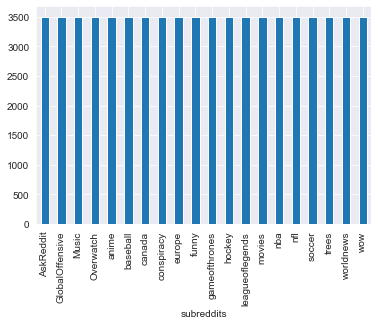

In [10]:
df.groupby("subreddits").comments.count().plot.bar(ylim = 0)
plt.show()

## Wordcloud of the most frequent words

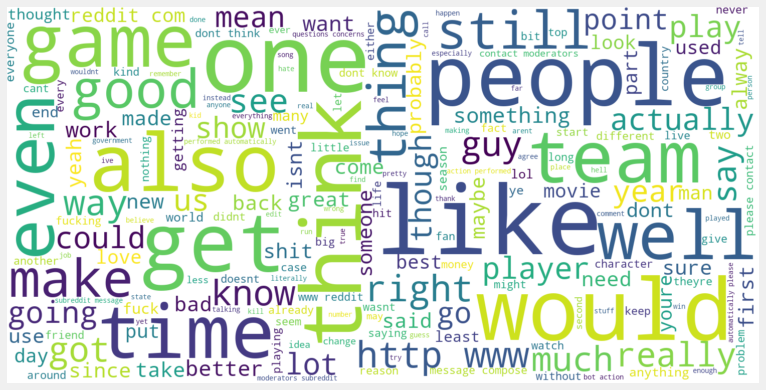

In [14]:
#Word Cloud 
plt.style.use('fivethirtyeight')
from wordcloud import WordCloud, STOPWORDS
string = []
for t in cleandata_Train:
    string.append(t)
string = pd.Series(string).str.cat(sep=' ')
wordcloud = WordCloud(width=1500, height=750,max_font_size=190,background_color='white', stopwords=stop_words).generate(string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

##### Find the most corelated unigrams and bigrams of each subreddit

In [41]:
#Find the most corelated unigrams and bigrams of each subreddit
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=2, norm='l2', 
                        encoding='latin-1', ngram_range=(1, 1), 
                        stop_words='english')

features = tfidf.fit_transform(cleandata_Train)#df.comments)
labels = df.subreddits
subreddit_classes = y_datatrain.unique()
N = 5
for subreddit_class in subreddit_classes:
    features_chi2 = chi2(features, labels == subreddit_class)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(subreddit_class))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'hockey':
  . Most correlated unigrams:
. crosby
. goalie
. leafs
. nhl
. hockey
  . Most correlated bigrams:
. 
# 'nba':
  . Most correlated unigrams:
. kd
. cavs
. nba
. kyrie
. lebron
  . Most correlated bigrams:
. 
# 'leagueoflegends':
  . Most correlated unigrams:
. adc
. riot
. na
. lane
. tsm
  . Most correlated bigrams:
. 
# 'soccer':
  . Most correlated unigrams:
. psg
. club
. chelsea
. neymar
. barca
  . Most correlated bigrams:
. 
# 'funny':
  . Most correlated unigrams:
. repost
. fap
. peta
. dog
. funny
  . Most correlated bigrams:
. 
# 'movies':
  . Most correlated unigrams:
. trailer
. films
. movies
. film
. movie
  . Most correlated bigrams:
. 
# 'anime':
  . Most correlated unigrams:
. myanimelist
. fate
. episode
. manga
. anime
  . Most correlated bigrams:
. 
# 'Overwatch':
  . Most correlated unigrams:
. genji
. hanzo
. doomfist
. mercy
. overwatch
  . Most correlated bigrams:
. 
# 'trees':
  . Most correlated unigrams:
. bong
. smoking
. trees
. smoke
. weed
 

## Confusion Matrix

In [40]:
def confusion_matrix(ypred, y_test):
    from sklearn.metrics import classification_report, confusion_matrix
    fig, ax = plt.subplots(figsize=(12,12))
    sns.heatmap(confusion_matrix(y_test, ypred, labels=np.unique(y_test)), annot=True, fmt="d", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test), ax=ax)
    #display(pd.DataFrame(confusion_matrix(y_test , ypred), columns=['Pred: Reddit','CS:GO','Overwatch','Music','anime','baseball','canada','conspiracy','europe','funny','GOT','hockey','movies','LOL','nba','soccer','nfl','trees','news','wow'], index=['AskReddit','GlobalOffensive','Overwatch','Music','anime','baseball','canada','conspiracy','europe','funny','GOT','hockey','movies','league of legends','nba','soccer','nfl','trees','news','wow']))
    print(classification_report(y_test,ypred))  
    Accuracy = accuracy_score(y_test, ypred)
    return Accuracy

## Pipeline to get a preliminary idea of the best features

In [130]:
# Defining a pipeline that prints the score, parameters, recall, precision, conf matrix of the best gridsearch model
pipe = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=stop_words,sublinear_tf=True,max_df=0.7,ngram_range=(1,1))),
    ("univ_select", SelectKBest(chi2)),
    ('nb', MultinomialNB())
])

grid_params = {
    #'tvec__max_df': (0.7,0.9),
    'tvec__min_df': (1,2),
    #'tvec__max_features': [20000, 25000,30000, 35000, 40000],
    #'tvec__ngram_range': ((1, 1), (1, 2)),
    "univ_select__k": [10000,15000],
    'nb__fit_prior': [True],
    'nb__alpha': [0.07, 0.1, 0.15, 0.2, 0.3],

}


X_training, X_testing, y_training, y_testing = train_test_split(cleandata_Train, y_datatrain, test_size=0.2,stratify=y_datatrain)
    
    grid_search = GridSearchCV(pipe, grid_params, cv = 5, verbose = 1, n_jobs = -1)
    grid_search.fit(X_training, y_training)

    print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
    # Printing the best score/parameters from the grid search
    print('Best score: {}'.format(grid_search.best_score_))
    print('Best paramters: {}'.format(grid_search.best_params_))

    # Best model from grid search
    grid_model = grid_search.best_estimator_
    print("Best estimator: ", grid_model)
    print('Model score on x_train: {}'.format(grid_model.score(X_training, y_training)))

    # Prediction and score
    prediction = grid_model.predict(X_testing)
    print('Accuracy score of prediction: {}'.format(accuracy_score(y_testing, prediction)))

    # Confusion Matrix
    conf_matrix_grid = confusion_matrix(y_testing, prediction)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.9min finished


Best cross-validation score: 0.55
Best score: 0.5476810179662365
Best paramters: {'nb__alpha': 0.2, 'nb__fit_prior': True, 'tvec__max_features': 20000, 'tvec__min_df': 1, 'univ_select__k': 15000}
Best estimator:  Pipeline(memory=None,
         steps=[('tvec',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.7, max_features=20000,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all'...
                                             'being', 'below', 'between',
                                

,Pred: Reddit,CS:GO,Overwatch,Music,anime,baseball,canada,conspiracy,europe,funny,GOT,hockey,movies,LOL,nba,soccer,nfl,trees,news,wow
AskReddit,214,12,35,15,29,15,56,26,26,127,11,18,15,44,19,21,23,62,42,12
GlobalOffensive,11,426,2,46,15,12,6,3,7,15,13,10,39,9,12,11,10,5,8,18
Overwatch,38,6,420,9,16,12,5,11,7,25,9,8,11,23,4,4,10,31,7,7
Music,16,32,7,465,14,9,7,9,4,13,4,8,52,7,8,9,8,4,6,30
anime,25,16,15,14,422,10,5,14,9,32,29,3,7,41,11,7,5,17,4,12
baseball,13,7,5,4,8,422,6,4,3,14,9,32,3,9,23,30,23,11,1,4
canada,53,8,19,5,15,6,349,62,57,42,10,17,5,12,7,14,11,23,100,6
conspiracy,29,14,19,20,9,13,41,322,36,48,17,7,8,19,15,20,17,21,129,13
europe,25,9,9,7,13,5,71,31,345,19,6,9,5,10,4,2,28,6,92,4
funny,85,24,17,21,29,10,27,38,29,148,13,17,15,36,14,20,23,56,28,17


                 precision    recall  f1-score   support

      AskReddit       0.31      0.26      0.28       822
GlobalOffensive       0.63      0.63      0.63       678
          Music       0.65      0.63      0.64       663
      Overwatch       0.68      0.65      0.66       712
          anime       0.60      0.60      0.60       698
       baseball       0.60      0.67      0.63       631
         canada       0.50      0.43      0.46       821
     conspiracy       0.46      0.39      0.43       817
         europe       0.49      0.49      0.49       700
          funny       0.21      0.22      0.22       667
  gameofthrones       0.67      0.76      0.71       566
         hockey       0.61      0.65      0.63       663
leagueoflegends       0.63      0.72      0.67       612
         movies       0.58      0.54      0.56       743
            nba       0.63      0.67      0.65       662
            nfl       0.60      0.65      0.63       651
         soccer       0.60    

## Count Vectorization along with TFIDF Transformation

In [16]:
vectorizer = CountVectorizer(stop_words='english',ngram_range=(1, 1),min_df=2,max_df=0.7)
X_train_vect = vectorizer.fit_transform(cleandata_Train) 
X_test_vect = vectorizer.transform(cleandata_Test)
X_train_vect.shape

(70000, 34044)

In [17]:
tfidfconverter = TfidfTransformer(sublinear_tf=True, use_idf =True, norm='l2')  
X_train_tfidf = tfidfconverter.fit_transform(X_train_vect)
X_test_tfidf = tfidfconverter.transform(X_test_vect)
X_tfidf=X_train_tfidf
y_train=y_datatrain

## CHI2 test to select K best features
(Novel method implemented: Select best features using a Chi^2 test rather than by frequency)

In [18]:
chi2_selector = SelectKBest(chi2, 15000)
X_tfidf_sel2 = chi2_selector.fit_transform(X_tfidf, y_train) 
X_test_tfidf_sel2 = chi2_selector.transform(X_test_tfidf)

In [647]:
# Basic multinomial NB - Only accuracy score
clf = MultinomialNB(alpha = 0.08, fit_prior = False)
pred_acc = cross_val_score(clf, X_tfidf_sel2, y_train, cv = 5)
print(pred_acc.mean())

0.5955571428571429


## TFIDF values of the most frequent words

In [19]:
dfmat = pd.DataFrame(data={"count":X_train_tfidf.sum(axis=0).tolist()[0], "name":vectorizer.get_feature_names()})
dfmat = dfmat.sort_values(by="count", ascending = False)

In [20]:
dfmat.head(20)

,count,name
17242,"1,241.35",like
8632,998.77,dont
30258,879.26,think
21996,866.36,people
12561,738.66,good
24246,705.48,really
30444,680.76,time
16447,673.88,know
17927,527.76,make
33843,511.01,youre


# Model selection and Evaluation

##### List of classifiers
     We have used the following models  in our project.
                  1. Linear SVC, 
                  2. Logistic Regression, 
                  3. Ridge Classifier, 
                  4. Stochastic Gradient Descent,
                  5. Multinominal Naive Bayes, 
                  6. Complement Naive Bayes
                  7. OneVsRest Classifier,
                  8. Bernoulli Naive Bayes from scratch,
                  9. Ensemble Methods
                    

#### Also we have used Ridge classifier, Multinomial Naive Bayes and Complement Naive Bayes with ensemble model.

In [37]:
#Spliting the dataset for training and validation:
X_training, X_testing, y_training, y_testing = train_test_split(X_tfidf_sel2, y_datatrain, test_size=0.2,stratify=y_datatrain) 

##### Linear SVC Model

In [650]:
#Linear SVC Model:
Cs = [0.01, 0.1, 0.5, 1, 1.5,2, 2.5, 3 ]
svc_clf = GridSearchCV(LinearSVC(), param_grid=dict(C=Cs), cv=5,verbose=1,n_jobs=-1)
start = time.time()
svc_clf.fit(X_training, y_training)    
print("Best cross-validation score: {:.2f}".format(svc_clf.best_score_))
print("Best parameters: ", svc_clf.best_params_)
print("Best estimator: ", svc_clf.best_estimator_)
svc_clf = svc_clf.best_estimator_
ypred_val_svc = svc_clf.predict(X_testing)
y_pred_test_svc = svc_clf.predict(X_tfidf_sel2)
end =  time.time()
print('Time to train and predict in Linear SVC Model: {}'.format(end-start))
confusion_matrix(ypred_val_svc, y_testing)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.3min finished


Best cross-validation score: 0.57
Best parameters:  {'C': 0.5}
Best estimator:  LinearSVC(C=0.5, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
Time to train and predict in Linear SVC Model: 86.39978694915771


,Pred: Reddit,CS:GO,Overwatch,Music,anime,baseball,canada,conspiracy,europe,funny,GOT,hockey,movies,LOL,nba,soccer,nfl,trees,news,wow
AskReddit,192,12,30,7,23,17,36,38,35,98,14,6,10,35,8,14,15,59,41,10
GlobalOffensive,11,469,13,31,7,10,7,12,10,15,5,2,25,9,6,10,23,16,5,14
Overwatch,31,6,490,10,9,4,7,13,5,28,5,10,4,20,5,11,6,21,10,5
Music,10,29,8,463,14,9,5,6,11,29,6,5,43,6,4,3,4,9,10,26
anime,37,9,16,11,451,9,8,15,7,32,7,2,8,39,2,4,10,16,10,7
baseball,15,9,7,9,11,465,10,5,5,19,6,17,7,14,24,21,24,17,5,10
canada,45,9,11,5,7,6,333,47,31,40,10,7,9,16,3,11,10,24,68,8
conspiracy,38,11,11,8,10,12,45,336,28,35,8,4,4,19,6,8,7,22,82,6
europe,23,6,6,5,8,5,41,33,399,27,4,6,4,12,3,6,15,18,73,6
funny,94,22,26,11,25,13,26,39,21,193,16,15,10,41,17,14,17,52,29,19


                 precision    recall  f1-score   support

      AskReddit       0.28      0.27      0.28       700
GlobalOffensive       0.66      0.67      0.66       700
          Music       0.66      0.70      0.68       700
      Overwatch       0.70      0.66      0.68       700
          anime       0.64      0.64      0.64       700
       baseball       0.67      0.66      0.67       700
         canada       0.48      0.48      0.48       700
     conspiracy       0.44      0.48      0.46       700
         europe       0.55      0.57      0.56       700
          funny       0.24      0.28      0.26       700
  gameofthrones       0.77      0.74      0.75       700
         hockey       0.71      0.63      0.67       700
leagueoflegends       0.71      0.70      0.71       700
         movies       0.57      0.60      0.58       700
            nba       0.71      0.64      0.67       700
            nfl       0.69      0.66      0.67       700
         soccer       0.64    

0.5840714285714286

##### Ridge Classifier

In [ ]:
from sklearn.linear_model import RidgeClassifier
#Ridge Classifier
param_grid = {'alpha': [0.5, 1, 2, 3],}
              #'solver' : ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}
grid = GridSearchCV(RidgeClassifier(class_weight = 'balanced',solver='saga',fit_intercept=False,normalize=True), param_grid, cv=5,verbose=1,n_jobs=-1)
start = time.time()
grid.fit(X_training, y_training)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)
rc = grid.best_estimator_
ypred_val_rc = rc.predict(X_testing)
y_pred_test_rc=rc.predict(X_tfidf_sel2)
end =  time.time()
print('Time to train and predict in Ridge Classifier Model: {}'.format(end-start))
confusion_matrix(ypred_val_rc, y_testing)

##### SGD Classifier

In [652]:
from sklearn.linear_model import SGDClassifier
#SGD Classifier
param_grid = {'alpha': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]}
grid = GridSearchCV(SGDClassifier(epsilon=0.1), param_grid, cv=5,verbose=1,n_jobs=-1)
start = time.time()
grid.fit(X_training, y_training)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)
sgd = grid.best_estimator_
ypred_val_sgd   = sgd.predict(X_testing)
y_pred_test_sgd = sgd.predict(X_tfidf_sel2)
end =  time.time()
print('Time to train and predict in Stochastic Gradient Descent Model: {}'.format(end-start))
confusion_matrix(ypred_val_sgd, y_testing)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   25.8s finished


Best cross-validation score: 0.56
Best parameters:  {'alpha': 1e-05}
Best estimator:  SGDClassifier(alpha=1e-05, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
Time to train and predict in Stochastic Gradient Descent Model: 29.46174120903015


,Pred: Reddit,CS:GO,Overwatch,Music,anime,baseball,canada,conspiracy,europe,funny,GOT,hockey,movies,LOL,nba,soccer,nfl,trees,news,wow
AskReddit,147,22,46,12,29,24,30,36,40,71,18,13,14,38,10,13,14,64,42,17
GlobalOffensive,8,465,8,35,6,10,4,13,13,16,6,6,29,8,8,10,17,11,8,19
Overwatch,24,8,503,11,13,7,7,14,3,18,7,10,4,9,7,9,6,19,12,9
Music,11,31,9,467,19,14,4,7,11,18,9,5,37,2,5,2,9,6,8,26
anime,23,10,19,13,462,13,7,12,10,25,10,6,7,36,5,3,9,14,6,10
baseball,15,9,13,14,6,463,10,10,7,15,6,17,3,11,28,24,20,16,3,10
canada,40,14,15,9,7,9,318,40,37,28,15,12,13,11,3,13,12,29,66,9
conspiracy,27,14,13,9,13,17,40,327,35,21,12,6,6,19,10,12,8,28,69,14
europe,14,9,12,8,9,8,34,35,405,20,8,8,6,11,5,4,14,21,62,7
funny,77,17,34,13,35,24,25,35,23,160,23,18,20,39,19,17,22,48,26,25


                 precision    recall  f1-score   support

      AskReddit       0.29      0.21      0.24       700
GlobalOffensive       0.64      0.66      0.65       700
          Music       0.62      0.72      0.67       700
      Overwatch       0.65      0.67      0.66       700
          anime       0.62      0.66      0.64       700
       baseball       0.62      0.66      0.64       700
         canada       0.52      0.45      0.48       700
     conspiracy       0.44      0.47      0.46       700
         europe       0.53      0.58      0.55       700
          funny       0.27      0.23      0.25       700
  gameofthrones       0.72      0.74      0.73       700
         hockey       0.65      0.63      0.64       700
leagueoflegends       0.68      0.70      0.69       700
         movies       0.59      0.58      0.59       700
            nba       0.66      0.65      0.66       700
            nfl       0.69      0.66      0.67       700
         soccer       0.62    

0.578

##### Bernoulli Naive Bayes

In [36]:
from sklearn.naive_bayes import BernoulliNB
#Bernoulli Naive Bayes
param_grid = {'alpha': [0.01, 0.1, 0.2, 0.5, 1]}
grid = GridSearchCV(BernoulliNB(fit_prior = False, binarize = 0.12), param_grid, cv=5,verbose=1,n_jobs=-1)
start = time.time()
grid.fit(X_training, y_training)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)
bnb = grid.best_estimator_
ypred_val_rc = bnb.predict(X_testing)
y_pred_test_rc=bnb.predict(X_tfidf_sel2)
end =  time.time()
print('Time to train and predict in Bernoulli Naive Bayes Model: {}'.format(end-start))
confusion_matrix(ypred_val_rc, y_testing)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.3s finished


Best cross-validation score: 0.57
Best parameters:  {'alpha': 0.1}
Best estimator:  BernoulliNB(alpha=0.1, binarize=0.12, class_prior=None, fit_prior=False)
Time to train and predict in Ridge Classifier Model: 1.8151700496673584


,Pred: Reddit,CS:GO,Overwatch,Music,anime,baseball,canada,conspiracy,europe,funny,GOT,hockey,movies,LOL,nba,soccer,nfl,trees,news,wow
AskReddit,194,13,13,5,20,11,36,29,21,163,6,8,5,42,7,7,13,67,32,8
GlobalOffensive,17,462,6,24,10,7,4,10,7,64,3,9,20,3,6,4,15,17,4,8
Overwatch,41,4,429,2,15,12,6,10,4,86,2,5,3,22,7,4,4,31,10,3
Music,14,31,6,453,21,8,2,14,2,52,6,5,25,9,9,4,7,13,5,14
anime,33,6,10,2,448,8,14,10,5,73,5,1,7,32,7,0,4,28,2,5
baseball,11,7,3,6,3,479,6,11,2,51,4,28,4,6,19,30,12,15,3,0
canada,37,7,2,7,9,4,314,42,43,87,2,6,1,5,7,3,10,41,71,2
conspiracy,38,6,5,2,7,7,42,319,37,92,3,5,3,15,4,2,8,29,71,5
europe,28,3,2,5,4,6,39,38,366,71,4,4,2,7,5,1,8,16,90,1
funny,98,11,13,3,12,19,27,30,18,308,6,4,6,35,8,11,14,47,22,8


                 precision    recall  f1-score   support

      AskReddit       0.26      0.28      0.27       700
GlobalOffensive       0.70      0.66      0.68       700
          Music       0.78      0.61      0.69       700
      Overwatch       0.78      0.65      0.71       700
          anime       0.65      0.64      0.64       700
       baseball       0.67      0.68      0.68       700
         canada       0.51      0.45      0.48       700
     conspiracy       0.47      0.46      0.46       700
         europe       0.59      0.52      0.55       700
          funny       0.18      0.44      0.26       700
  gameofthrones       0.87      0.65      0.74       700
         hockey       0.71      0.63      0.67       700
leagueoflegends       0.78      0.63      0.70       700
         movies       0.61      0.62      0.61       700
            nba       0.70      0.66      0.68       700
            nfl       0.72      0.64      0.68       700
         soccer       0.70    

0.5752142857142857

##### Multinomial Naive Bayes

In [23]:
#Multinominal Naive Bayes Classifier:
param_grid = {
            'fit_prior': [True],
            'alpha': [0.05, 0.07, 0.08, 0.1, 0.15]}
grid = GridSearchCV(MultinomialNB(), param_grid, cv=5,n_jobs=-1)
start = time.time()
grid.fit(X_training, y_training)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)
mnb = grid.best_estimator_
ypred_val_mnb   = mnb.predict(X_testing)
y_pred_test_mnb = mnb.predict(X_tfidf_sel2)
end =  time.time()
print('Time to train and predict in Multinominal Naive Bayes Model: {}'.format(end-start))
confusion_matrix(ypred_val_mnb, y_testing)

Best cross-validation score: 0.59
Best parameters:  {'alpha': 0.07, 'fit_prior': True}
Best estimator:  MultinomialNB(alpha=0.07, class_prior=None, fit_prior=True)
Time to train and predict in Multinominal Naive Bayes Model: 3.761303186416626


,Pred: Reddit,CS:GO,Overwatch,Music,anime,baseball,canada,conspiracy,europe,funny,GOT,hockey,movies,LOL,nba,soccer,nfl,trees,news,wow
AskReddit,245,9,28,12,23,9,44,32,21,89,12,5,6,44,5,12,9,50,38,7
GlobalOffensive,17,465,8,25,12,10,8,19,8,25,3,3,26,7,9,9,17,13,6,10
Overwatch,50,8,436,5,17,5,7,13,7,40,4,6,3,30,4,8,4,34,8,11
Music,13,33,9,497,9,5,6,9,2,22,5,2,16,19,7,6,6,9,9,16
anime,32,5,13,5,485,7,7,10,4,26,13,1,3,38,7,4,6,20,7,7
baseball,21,6,11,7,9,446,10,12,5,31,2,27,2,11,24,35,11,14,11,5
canada,52,5,7,6,5,2,358,38,59,34,5,6,3,7,2,6,5,24,72,4
conspiracy,40,5,7,4,2,4,57,340,28,42,8,3,7,18,3,4,1,30,92,5
europe,30,6,6,5,7,2,46,39,391,32,8,1,4,5,1,7,10,12,82,6
funny,114,20,23,14,21,15,28,30,26,205,18,9,9,35,6,16,16,57,28,10


                 precision    recall  f1-score   support

      AskReddit       0.27      0.35      0.31       700
GlobalOffensive       0.69      0.66      0.68       700
          Music       0.66      0.62      0.64       700
      Overwatch       0.69      0.71      0.70       700
          anime       0.69      0.69      0.69       700
       baseball       0.73      0.64      0.68       700
         canada       0.49      0.51      0.50       700
     conspiracy       0.44      0.49      0.46       700
         europe       0.57      0.56      0.56       700
          funny       0.24      0.29      0.26       700
  gameofthrones       0.79      0.72      0.76       700
         hockey       0.78      0.65      0.71       700
leagueoflegends       0.78      0.64      0.70       700
         movies       0.58      0.65      0.61       700
            nba       0.71      0.67      0.69       700
            nfl       0.65      0.66      0.66       700
         soccer       0.75    

0.593

#####  Complement Naive Bayes

In [664]:
from sklearn.naive_bayes import ComplementNB
#Complement Naive Bayes Classifier:
param_grid = {
            'fit_prior': [True],
            'alpha': [0.4, 0.5, 0.6]}
grid = GridSearchCV(ComplementNB(), param_grid, cv=5,n_jobs=-1)
start = time.time()
grid.fit(X_training, y_training)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)
cnb = grid.best_estimator_
ypred_val_cnb   = cnb.predict(X_testing)
y_pred_test_cnb = cnb.predict(X_tfidf_sel2)
end =  time.time()
print('Time to train and predict in Multinominal Naive Bayes Model: {}'.format(end-start))
confusion_matrix(ypred_val_cnb, y_testing)

Best cross-validation score: 0.59
Best parameters:  {'alpha': 0.6, 'fit_prior': True}
Best estimator:  ComplementNB(alpha=0.6, class_prior=None, fit_prior=True, norm=False)
Time to train and predict in Multinominal Naive Bayes Model: 2.5628182888031006


,Pred: Reddit,CS:GO,Overwatch,Music,anime,baseball,canada,conspiracy,europe,funny,GOT,hockey,movies,LOL,nba,soccer,nfl,trees,news,wow
AskReddit,170,14,41,14,32,11,55,40,33,63,19,6,9,42,5,16,14,58,42,16
GlobalOffensive,10,467,18,37,12,8,5,12,15,13,6,2,20,9,8,4,18,14,8,14
Overwatch,18,8,521,18,14,2,12,9,6,10,5,6,6,17,5,5,7,19,6,6
Music,11,24,16,502,9,8,4,10,6,18,13,6,23,9,2,4,3,6,2,24
anime,19,8,26,19,482,5,10,16,6,14,9,1,5,35,5,6,4,15,4,11
baseball,14,6,19,13,10,486,7,8,5,11,9,16,5,9,26,23,13,8,2,10
canada,28,11,20,6,8,3,378,36,44,20,17,6,8,10,3,12,9,24,50,7
conspiracy,22,9,28,6,8,5,55,325,29,16,23,4,9,18,5,11,7,32,79,9
europe,12,6,17,8,10,7,49,38,429,13,12,5,4,11,4,6,7,10,49,3
funny,73,19,47,21,33,16,33,32,23,127,34,17,14,48,25,12,17,55,27,27


                 precision    recall  f1-score   support

      AskReddit       0.33      0.24      0.28       700
GlobalOffensive       0.67      0.67      0.67       700
          Music       0.56      0.74      0.64       700
      Overwatch       0.64      0.72      0.68       700
          anime       0.64      0.69      0.66       700
       baseball       0.76      0.69      0.73       700
         canada       0.48      0.54      0.51       700
     conspiracy       0.43      0.46      0.45       700
         europe       0.55      0.61      0.58       700
          funny       0.29      0.18      0.22       700
  gameofthrones       0.67      0.78      0.72       700
         hockey       0.74      0.64      0.69       700
leagueoflegends       0.75      0.70      0.72       700
         movies       0.59      0.64      0.62       700
            nba       0.70      0.67      0.69       700
            nfl       0.69      0.68      0.69       700
         soccer       0.70    

0.6002142857142857

##### OneVsRest Classifier using Bernoulli Naive Bayes

In [38]:
from sklearn.multiclass import OneVsRestClassifier
#OneVsRest Model:
ovr_mnb=OneVsRestClassifier(BernoulliNB(alpha=0.1, binarize=0.12, class_prior=None, fit_prior=False),n_jobs=-1)
start = time.time()
ovr_mnb.fit(X_training, y_training)    
ypred_val_ovrmnb = ovr_mnb.predict(X_testing)
y_pred_test_ovrmnb = ovr_mnb.predict(X_tfidf_sel2)
end =  time.time()
print('Time to train and predict in OneVsRest Multinomial Naive Bayes Model: {}'.format(end-start))
confusion_matrix(ypred_val_ovrmnb, y_testing)

Time to train and predict in OneVsRest Multinomial Naive Bayes Model: 2.18916916847229


,Pred: Reddit,CS:GO,Overwatch,Music,anime,baseball,canada,conspiracy,europe,funny,GOT,hockey,movies,LOL,nba,soccer,nfl,trees,news,wow
AskReddit,199,8,26,5,25,6,40,28,25,158,4,7,4,37,8,4,12,67,23,14
GlobalOffensive,13,472,7,30,10,8,4,10,9,40,1,8,31,10,7,5,15,14,2,4
Overwatch,29,6,440,1,17,7,7,15,7,69,2,9,3,23,6,4,2,43,9,1
Music,4,34,2,461,15,5,8,8,3,60,3,7,31,11,4,1,9,15,3,16
anime,21,7,11,7,486,8,9,7,1,56,11,2,6,33,2,1,4,20,3,5
baseball,20,4,6,6,2,458,4,5,0,49,3,29,4,9,34,26,16,17,4,4
canada,41,1,4,3,1,5,330,31,33,101,1,16,3,9,4,3,9,31,72,2
conspiracy,39,9,5,2,8,4,37,334,34,79,2,5,3,16,2,3,4,25,84,5
europe,22,7,5,4,6,5,34,37,385,60,2,4,1,6,5,4,8,19,84,2
funny,103,13,13,5,27,9,30,24,18,279,3,5,4,43,7,7,11,71,20,8


                 precision    recall  f1-score   support

      AskReddit       0.29      0.28      0.29       700
GlobalOffensive       0.69      0.67      0.68       700
          Music       0.76      0.63      0.69       700
      Overwatch       0.77      0.66      0.71       700
          anime       0.69      0.69      0.69       700
       baseball       0.74      0.65      0.69       700
         canada       0.54      0.47      0.50       700
     conspiracy       0.49      0.48      0.49       700
         europe       0.58      0.55      0.56       700
          funny       0.18      0.40      0.25       700
  gameofthrones       0.88      0.70      0.78       700
         hockey       0.72      0.70      0.71       700
leagueoflegends       0.79      0.70      0.74       700
         movies       0.63      0.66      0.64       700
            nba       0.72      0.69      0.70       700
            nfl       0.75      0.65      0.69       700
         soccer       0.72    

0.598

##### OneVsRest Classifier using Multinomial Naive Bayes

In [34]:
from sklearn.multiclass import OneVsRestClassifier
#OneVsRest Model:
ovr_mnb=OneVsRestClassifier(MultinomialNB(alpha=0.07),n_jobs=-1)
start = time.time()
ovr_mnb.fit(X_training, y_training)    
ypred_val_ovrmnb = ovr_mnb.predict(X_testing)
y_pred_test_ovrmnb = ovr_mnb.predict(X_tfidf_sel2)
end =  time.time()
print('Time to train and predict in OneVsRest Multinomial Naive Bayes Model: {}'.format(end-start))
confusion_matrix(ypred_val_ovrmnb, y_testing)

Time to train and predict in OneVsRest Multinomial Naive Bayes Model: 0.8994519710540771


,Pred: Reddit,CS:GO,Overwatch,Music,anime,baseball,canada,conspiracy,europe,funny,GOT,hockey,movies,LOL,nba,soccer,nfl,trees,news,wow
AskReddit,220,8,22,10,23,10,43,20,23,146,6,6,4,43,3,7,9,67,25,5
GlobalOffensive,12,450,6,25,11,13,7,11,5,68,0,3,22,5,8,5,17,23,3,6
Overwatch,34,6,422,2,16,7,7,6,6,66,2,8,1,41,5,6,4,45,10,6
Music,7,29,7,483,10,8,3,6,5,55,4,2,19,15,7,3,6,12,4,15
anime,20,6,11,3,484,8,3,5,4,56,9,4,1,40,6,2,7,23,2,6
baseball,15,5,5,4,8,457,5,8,3,55,4,28,1,8,28,26,11,21,6,2
canada,48,5,7,5,3,3,353,37,48,74,0,7,2,5,2,4,9,26,59,3
conspiracy,37,4,7,2,3,5,56,331,31,76,3,7,5,17,3,3,2,32,72,4
europe,19,5,6,4,8,1,44,33,399,60,6,2,2,7,0,6,8,21,65,4
funny,95,15,17,6,25,14,24,28,17,285,9,7,6,27,7,15,17,61,19,6


                 precision    recall  f1-score   support

      AskReddit       0.30      0.31      0.31       700
GlobalOffensive       0.71      0.64      0.68       700
          Music       0.74      0.60      0.66       700
      Overwatch       0.75      0.69      0.72       700
          anime       0.70      0.69      0.69       700
       baseball       0.71      0.65      0.68       700
         canada       0.52      0.50      0.51       700
     conspiracy       0.48      0.47      0.47       700
         europe       0.59      0.57      0.58       700
          funny       0.19      0.41      0.26       700
  gameofthrones       0.85      0.69      0.76       700
         hockey       0.75      0.69      0.72       700
leagueoflegends       0.83      0.64      0.72       700
         movies       0.60      0.66      0.63       700
            nba       0.72      0.69      0.70       700
            nfl       0.72      0.65      0.68       700
         soccer       0.73    

0.5945714285714285

##### OneVsRest Classifier using Complement Naive Bayes

In [682]:
from sklearn.multiclass import OneVsRestClassifier
#OneVsRest Model:
ovr_cnb=OneVsRestClassifier(ComplementNB(alpha=0.6),n_jobs=-1)
ovr_cnb.fit(X_training, y_training)    
ypred_val_overcnb = ovr_cnb.predict(X_testing)
y_pred_test_ovrcnb = ovr_cnb.predict(X_tfidf_sel2)
end =  time.time()
print('Time to train and predict in OneVsRest Complement Naive Bayes Model: {}'.format(end-start))
confusion_matrix(ypred_val_ovrcnb, y_testing)

,Pred: Reddit,CS:GO,Overwatch,Music,anime,baseball,canada,conspiracy,europe,funny,GOT,hockey,movies,LOL,nba,soccer,nfl,trees,news,wow
AskReddit,226,12,37,9,21,7,51,38,29,66,14,5,9,49,3,10,9,63,33,9
GlobalOffensive,15,471,19,35,7,4,4,16,12,9,6,2,30,9,6,5,16,14,4,16
Overwatch,38,5,501,11,14,2,9,7,4,19,5,6,0,19,9,7,4,26,11,3
Music,13,26,14,496,16,7,4,11,6,20,6,4,25,9,3,2,3,8,6,21
anime,23,3,22,16,479,5,11,22,7,12,7,4,6,35,3,5,4,22,4,10
baseball,20,7,18,14,8,468,6,8,2,15,3,17,5,7,26,32,15,12,5,12
canada,39,9,12,6,6,2,379,44,45,27,9,7,5,10,0,10,6,22,58,4
conspiracy,33,7,23,6,15,3,62,352,24,17,13,4,6,20,1,6,1,24,77,6
europe,22,7,15,10,12,5,47,41,409,17,10,5,2,10,2,4,7,14,60,1
funny,110,21,29,18,31,10,34,37,16,156,21,6,9,47,15,10,14,67,33,16


                 precision    recall  f1-score   support

      AskReddit       0.31      0.32      0.32       700
GlobalOffensive       0.70      0.67      0.68       700
          Music       0.60      0.72      0.65       700
      Overwatch       0.66      0.71      0.68       700
          anime       0.64      0.68      0.66       700
       baseball       0.80      0.67      0.73       700
         canada       0.47      0.54      0.51       700
     conspiracy       0.43      0.50      0.46       700
         europe       0.58      0.58      0.58       700
          funny       0.29      0.22      0.25       700
  gameofthrones       0.76      0.76      0.76       700
         hockey       0.76      0.64      0.69       700
leagueoflegends       0.77      0.70      0.74       700
         movies       0.59      0.66      0.62       700
            nba       0.72      0.68      0.70       700
            nfl       0.70      0.68      0.69       700
         soccer       0.74    

0.6052857142857143

##### Logistic Regression

In [542]:
#Logistic Regression
param_grid = {'C': [1, 10, 100, 1000 ],
                 'multi_class':['multinomial','ovr']}
grid = GridSearchCV(LogisticRegression(solver='lbfgs'), param_grid, cv=5,verbose=1,n_jobs=-1)
start = time.time()
grid.fit(X_training, y_training)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)
lr = grid.best_estimator_
ypred_val_lr = lr.predict(X_testing)
y_pred_test_lr=lr.predict(X_tfidf_sel2)
end =  time.time()
print('Time to train and predict in Logistic Regression Model: {}'.format(end-start))
confusion_matrix(ypred_val_lr, y_testing)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  4.0min finished


Best cross-validation score: 0.55
Best parameters:  {'C': 10, 'multi_class': 'ovr'}
Best estimator:  LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Time to train and predict in Logistic Regression Model: 268.332083940506


,Pred: Reddit,CS:GO,Overwatch,Music,anime,baseball,canada,conspiracy,europe,funny,GOT,hockey,movies,LOL,nba,soccer,nfl,trees,news,wow
AskReddit,219,12,28,8,19,17,32,36,27,95,14,4,13,39,10,10,14,46,40,17
GlobalOffensive,16,456,10,22,8,11,5,16,11,20,5,11,34,5,11,6,15,18,9,11
Overwatch,36,7,461,5,18,6,8,15,9,29,8,5,3,23,5,6,7,31,10,8
Music,17,35,7,470,21,6,12,4,4,28,3,3,24,11,6,6,8,15,8,12
anime,34,8,18,11,430,12,7,8,10,37,14,5,6,36,9,7,5,22,13,8
baseball,18,10,7,4,7,442,11,14,6,32,3,22,10,5,25,33,18,16,9,8
canada,52,5,6,7,10,5,337,39,31,56,4,7,2,11,6,14,12,20,68,8
conspiracy,32,12,9,6,10,8,49,307,39,53,3,5,5,14,6,7,13,20,93,9
europe,36,10,6,1,7,2,49,46,351,33,10,6,4,8,6,6,11,11,92,5
funny,104,11,27,13,19,8,22,35,37,213,19,8,7,27,12,12,19,59,36,12


                 precision    recall  f1-score   support

      AskReddit       0.27      0.31      0.29       700
GlobalOffensive       0.65      0.65      0.65       700
          Music       0.67      0.66      0.66       700
      Overwatch       0.73      0.67      0.70       700
          anime       0.63      0.61      0.62       700
       baseball       0.69      0.63      0.66       700
         canada       0.51      0.48      0.49       700
     conspiracy       0.41      0.44      0.42       700
         europe       0.51      0.50      0.51       700
          funny       0.23      0.30      0.26       700
  gameofthrones       0.77      0.72      0.74       700
         hockey       0.69      0.58      0.63       700
leagueoflegends       0.72      0.67      0.69       700
         movies       0.60      0.58      0.59       700
            nba       0.67      0.66      0.66       700
            nfl       0.65      0.60      0.63       700
         soccer       0.64    

,Pred: Reddit,CS:GO,Overwatch,Music,anime,baseball,canada,conspiracy,europe,funny,GOT,hockey,movies,LOL,nba,soccer,nfl,trees,news,wow
AskReddit,34,34,29,35,40,23,43,45,45,48,30,40,32,43,44,22,23,30,29,31
GlobalOffensive,34,23,38,36,31,38,44,36,37,38,35,37,32,48,25,33,35,31,38,31
Overwatch,42,27,42,32,32,25,42,41,38,36,34,36,27,37,31,24,39,42,34,39
Music,32,38,38,38,36,38,38,54,27,39,28,25,32,36,32,32,28,44,30,35
anime,43,37,29,32,31,34,43,42,41,46,32,28,34,40,34,31,26,34,36,27
baseball,39,33,30,37,34,29,38,44,39,42,24,25,37,41,36,36,30,43,23,40
canada,55,33,27,36,31,32,34,44,36,46,28,27,29,39,35,37,34,39,34,24
conspiracy,36,23,34,32,36,27,37,35,44,39,35,32,37,34,28,40,36,37,39,39
europe,40,30,39,32,41,23,25,44,27,47,30,33,37,39,39,30,22,52,25,45
funny,46,41,36,43,46,36,39,29,28,41,34,30,34,34,30,28,19,37,35,34


                 precision    recall  f1-score   support

      AskReddit       0.04      0.05      0.05       700
GlobalOffensive       0.03      0.03      0.03       700
          Music       0.06      0.06      0.06       700
      Overwatch       0.05      0.05      0.05       700
          anime       0.04      0.04      0.04       700
       baseball       0.05      0.04      0.04       700
         canada       0.05      0.05      0.05       700
     conspiracy       0.04      0.05      0.05       700
         europe       0.04      0.04      0.04       700
          funny       0.05      0.06      0.05       700
  gameofthrones       0.06      0.05      0.05       700
         hockey       0.07      0.06      0.07       700
leagueoflegends       0.04      0.03      0.04       700
         movies       0.04      0.05      0.05       700
            nba       0.06      0.05      0.06       700
            nfl       0.05      0.05      0.05       700
         soccer       0.04    

0.046857142857142854

##### Ensemble Methods

In [669]:
from sklearn.ensemble import VotingClassifier
estimators=[('Complement NB', cnb), ('Multinomial Naive Bayes', mnb),('Ridge',rc)]
ensemble = VotingClassifier(estimators, voting='hard')
start = time.time()
#Fitting the model on training data
ensemble.fit(X_training, y_training)
ypred_val_en   = ensemble.predict(X_testing)
y_pred_test_en = ensemble.predict(X_tfidf_sel2)
end =  time.time()
#test our model on the test data            
ensemble.score(X_testing, y_testing)
print('Time to train and predict in Ensemble model: {}'.format(end-start))
confusion_matrix(ypred_val_en, y_testing)

Time to train and predict in Ensemble model: 17.231451988220215


,Pred: Reddit,CS:GO,Overwatch,Music,anime,baseball,canada,conspiracy,europe,funny,GOT,hockey,movies,LOL,nba,soccer,nfl,trees,news,wow
AskReddit,227,11,34,10,25,11,48,38,28,73,16,7,8,39,3,12,10,54,38,8
GlobalOffensive,17,487,14,34,8,8,6,14,14,11,6,2,17,7,5,4,17,15,4,10
Overwatch,34,4,514,14,13,2,10,8,3,18,4,6,2,19,6,5,4,19,9,6
Music,16,28,11,490,13,7,3,9,7,25,9,4,28,7,3,4,4,6,3,23
anime,29,11,19,16,486,8,10,21,6,20,4,2,4,30,2,3,5,14,3,7
baseball,19,7,14,12,9,496,8,6,3,16,4,13,5,7,23,21,14,12,3,8
canada,41,11,14,7,8,3,383,34,41,29,13,6,6,7,1,10,6,21,54,5
conspiracy,36,13,20,7,10,7,57,349,24,18,12,5,7,16,4,7,4,26,73,5
europe,25,6,14,8,13,5,47,41,424,17,4,5,2,11,3,3,8,12,51,1
funny,107,27,39,17,34,11,26,32,18,174,21,9,9,42,18,8,14,53,25,16


                 precision    recall  f1-score   support

      AskReddit       0.29      0.32      0.31       700
GlobalOffensive       0.66      0.70      0.67       700
          Music       0.60      0.73      0.66       700
      Overwatch       0.66      0.70      0.68       700
          anime       0.64      0.69      0.67       700
       baseball       0.76      0.71      0.73       700
         canada       0.49      0.55      0.52       700
     conspiracy       0.44      0.50      0.47       700
         europe       0.58      0.61      0.59       700
          funny       0.29      0.25      0.27       700
  gameofthrones       0.76      0.77      0.76       700
         hockey       0.76      0.64      0.69       700
leagueoflegends       0.78      0.71      0.74       700
         movies       0.61      0.64      0.62       700
            nba       0.73      0.67      0.70       700
            nfl       0.74      0.68      0.71       700
         soccer       0.72    

0.6094285714285714

In [723]:
from sklearn.ensemble import VotingClassifier
estimators=[('Complement NB', ovr_cnb), ('Multinomial Naive Bayes', ovr_mnb),('Ridge',rc)]
ensemble_ovr = VotingClassifier(estimators, voting='hard')
start = time.time()
#Fitting the model on traininf data
ensemble_ovr.fit(X_training, y_training)
ypred_val_en   = ensemble_ovr.predict(X_testing)
y_pred_test_en = ensemble_ovr.predict(X_tfidf_sel2)
end =  time.time()
#test our model on the test data            
ensemble_ovr.score(X_testing, y_testing)
print('Time to train and predict in Ensemble model: {}'.format(end-start))
confusion_matrix(ypred_val_en, y_testing)

Time to train and predict in Ensemble model: 8.203211069107056


,Pred: Reddit,CS:GO,Overwatch,Music,anime,baseball,canada,conspiracy,europe,funny,GOT,hockey,movies,LOL,nba,soccer,nfl,trees,news,wow
AskReddit,241,13,33,7,19,8,46,37,31,73,14,6,6,41,1,10,10,59,37,8
GlobalOffensive,15,484,14,33,6,6,3,17,14,10,6,2,27,9,3,6,15,13,4,13
Overwatch,40,5,503,12,12,2,9,8,4,21,5,5,1,18,7,6,4,25,10,3
Music,14,28,10,491,15,6,2,10,8,25,7,4,28,8,3,2,4,8,5,22
anime,26,6,21,14,480,7,9,20,7,17,5,4,5,34,3,4,4,21,5,8
baseball,21,6,16,13,6,479,6,8,2,19,3,18,5,8,23,24,16,12,4,11
canada,45,8,11,7,7,2,380,43,45,28,9,6,5,9,0,10,6,18,56,5
conspiracy,40,8,20,6,12,5,58,356,25,20,9,5,6,18,1,6,1,23,75,6
europe,26,7,10,9,10,6,46,40,414,18,7,5,2,11,2,3,9,14,60,1
funny,110,24,30,18,29,10,31,35,16,179,17,6,10,43,16,9,14,59,31,13


                 precision    recall  f1-score   support

      AskReddit       0.30      0.34      0.32       700
GlobalOffensive       0.68      0.69      0.69       700
          Music       0.62      0.72      0.67       700
      Overwatch       0.67      0.70      0.69       700
          anime       0.66      0.69      0.67       700
       baseball       0.78      0.68      0.73       700
         canada       0.49      0.54      0.51       700
     conspiracy       0.43      0.51      0.47       700
         europe       0.58      0.59      0.59       700
          funny       0.29      0.26      0.27       700
  gameofthrones       0.78      0.76      0.77       700
         hockey       0.75      0.64      0.69       700
leagueoflegends       0.78      0.71      0.74       700
         movies       0.60      0.65      0.62       700
            nba       0.73      0.67      0.70       700
            nfl       0.72      0.69      0.71       700
         soccer       0.74    

0.6102142857142857

In [ ]:
from sklearn.ensemble import VotingClassifier
estimators=[('Complement NB', ovr_cnb), ('Multinomial Naive Bayes', ovr_mnb),('Bernoulli Naive Bayes', ovr_bnb), ('Ridge',rc)]
ensemble_ovr = VotingClassifier(estimators, voting='hard')
start = time.time()
#Fitting the model on traininf data
ensemble_ovr.fit(X_training, y_training)
ypred_val_en   = ensemble_ovr.predict(X_testing)
y_pred_test_en = ensemble_ovr.predict(X_tfidf_sel2)
end =  time.time()
#test our model on the test data            
ensemble_ovr.score(X_testing, y_testing)
print('Time to train and predict in Ensemble model: {}'.format(end-start))
confusion_matrix(ypred_val_en, y_testing)

## Fitting Ensemble Method on the full training data

In [39]:
#Ensemble fit over the full data
ensemble.fit(X_tfidf_sel2,y_datatrain)
y_pred_test_en = ensemble.predict(X_test_tfidf_sel2)

NameError: name 'ensemble' is not defined

## Saving File 

In [22]:
rawdata= { 'Category': y_pred_test_en }
a = pd.DataFrame(rawdata, columns = ['Category'])
a.to_csv('y_pred.csv',index=True, header=True)

NameError: name 'y_pred_test_svc' is not defined

### Bernoulli Naive Bayes from Scratch

In [27]:
import numpy as np
import scipy.sparse

class NaiveBayes: 
    
    def __init__(self):
        self.theta_k=0.
        self.theta_jk=0.
        
    def fit(self,X,y):
        index=[]
        self.theta_jk=np.zeros((20,X.shape[1]))
        self.theta_k=np.zeros(20)
        
        self.classes = np.unique(y)
        
        #calculating theta  for each 
        for k, class_val in enumerate(self.classes):
            #finding indexes where inputs are in class k
            index=np.where(y==class_val)
            #finding pobability of each class
            self.theta_k[k] = (len(index[0]))/float(y.shape[0])
            #computing conditional probability of each feature for each class 
            #Laplace smoothing is used to deal with words which are not observed 
            #in the training data but are available in the training set
            self.theta_jk[k][:] = (scipy.sparse.csr_matrix.sum(X[index],axis=0)+1)/(float(len(index[0]))+2)
                  
        return
    
    def predict(self,X):
        
        prob_y=np.zeros((20,len(X)))
        for k, class_val in enumerate(self.classes):
            
            w0 = np.log(self.theta_k[k])+((np.log(1-self.theta_jk[k][:])).sum())
            w = np.log(self.theta_jk[k][:])-np.log(1-self.theta_jk[k][:])
            #The probabilitis of being in each of k classes for each of input data(comments)
            prob_y[k]=np.matmul(X,w.T) + w0  
        #selecting the class with higher probability for each input data (comment)
        y_predict=self.classes[np.argmax(prob_y.T, axis=1)]

        return y_predict
    
    def score(self,y,y_pred):
        #number of predictions       
        num_pred = np.float(len(y))
        #calculating average accuracy over all classes
        average_acc = np.sum((y==y_pred)*1)/num_pred
        #calculating accuracy for each class 
        acc=np.zeros(20)
        
        #classes = np.unique(y)
        
        for k, class_val in enumerate(self.classes): 
            index=np.where(y==class_val)
            num_pred=np.float(len(index[0]))
            #acc array contains accuracies for each of 20 classes in the order of
            #the below dictionary:
            #dictionary={'anime':0, 'Music':1, 'trees':2, 'conspiracy':3, 'canada':4, 'hockey':5, 
            #'worldnews':6, 'funny':7, 'GlobalOffensive':8, 'AskReddit':9, 'nba':10, 
            #'nfl':11, 'europe':12, 'soccer':13, 'wow':14 , 'Overwatch':15,
            #'gameofthrones':16, 'movies':17, 'leagueoflegends':18,'baseball':19} 
            acc[k]= (np.sum(y_pred[index]==class_val).astype(np.int))/num_pred
        return acc,average_acc
    
    def get_classes(self):
        return self.classes
    
def test(X_training, y_training, X_testing, y_testing):
    
    
    d = NaiveBayes()
    
    #X_training = X_train  
    y_training = np.array(y_training)
    X_testing = X_testing.toarray()
    y_testing = np.array(y_testing)
    d.fit(X_training, y_training)
    y_prediction = d.predict(X_testing)
    (acc, average_acc) = d.score(y_testing, y_prediction)
    print("Average accuracy on test set: ", average_acc)
    print("\nAccuracy on test set for each class: ")
    for a,b in zip(d.get_classes(),acc):
        print(a, ": ", b)
        
test(X_training, y_training, X_testing, y_testing)     
        

Average accuracy on test set:  0.5617142857142857

Accuracy on test set for each class: 
AskReddit :  0.29
GlobalOffensive :  0.6485714285714286
Music :  0.52
Overwatch :  0.6785714285714286
anime :  0.6185714285714285
baseball :  0.6228571428571429
canada :  0.4642857142857143
conspiracy :  0.3942857142857143
europe :  0.5071428571428571
funny :  0.4685714285714286
gameofthrones :  0.6657142857142857
hockey :  0.6142857142857143
leagueoflegends :  0.5971428571428572
movies :  0.6328571428571429
nba :  0.6742857142857143
nfl :  0.6128571428571429
soccer :  0.6314285714285715
trees :  0.6
worldnews :  0.2957142857142857
wow :  0.6971428571428572


## Doc2Vec Implemetation using Logistic Regression

In [ ]:
from gensim.models import Doc2Vec
from sklearn import utils
from gensim.models.doc2vec import TaggedDocument

In [ ]:
def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(TaggedDocument(v.split(), [label]))
    return labeled

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(cleandata_Train, y_datatrain, random_state=1, test_size=0.2)
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

In [ ]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

In [ ]:
for epoch in range(10):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

In [ ]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

In [ ]:
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

In [ ]:
logreg = LogisticRegression(n_jobs=-1, C=1e5)
logreg.fit(train_vectors_dbow, y_train)
logreg = logreg.fit(train_vectors_dbow, y_train)
y_pred = logreg.predict(test_vectors_dbow)

In [ ]:
from sklearn.metrics import classification_report
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))